# INTRODUCTION

El desafío que se presenta en esta competencia de Kaggle trata sobre la **predicción del costo de campañas publicitarias** de una cadena de tiendas de conveniencia llamada **Convenient Food Mart** (CFM), utilizando un conjunto de datos tabular. El objetivo principal es construir un modelo de *Machine Learning* que sea capaz de predecir el costo de las campañas de marketing basándose en varias características de las tiendas y sus productos.

### **Contexto y datos**:
- **Convenient Food Mart** es una cadena de tiendas de conveniencia en los Estados Unidos con sede en Ohio.
- La competencia se basa en datos generados sintéticamente, pero representan escenarios realistas con características específicas de las tiendas, como el área del local, la cantidad de productos vendidos, las características de los productos (bajo en grasa, reciclable, etc.), y servicios adicionales en las tiendas como barra de café o floristería.
  
### **Características del conjunto de datos**:
Algunas de las variables en el conjunto de datos incluyen:
- **store_sales**: Ventas en millones de dólares.
- **unit_sales**: Unidades vendidas en millones.
- **Total_children**: Total de niños en los hogares de los clientes.
- **avg_cars_at_home**: Número promedio de autos por hogar.
- **Recyclable_package**: Si el producto es reciclable o no.
- **Low_fat**: Si el producto es bajo en grasa.
- **Cost**: Este es el valor objetivo que debemos predecir: el costo de la campaña publicitaria.

### **Objetivo del proyecto**:
El desafío es construir un modelo de regresión que prediga con precisión el costo de las campañas de marketing basándose en los datos proporcionados. La evaluación se realizará utilizando el error cuadrático medio logarítmico (RMSLE), que penaliza más los errores en predicciones que subestimen los valores reales.

### **Evaluación**:
Los modelos se puntúan utilizando **RMSLE** (*Root Mean Squared Logarithmic Error*), una métrica que mide las diferencias entre los valores logarítmicos de las predicciones y los valores reales, dando más peso a las diferencias porcentuales que a las absolutas.

In [1]:
from google.colab import drive
import os

# Montar el drive
drive.mount('/content/drive')

# Establecer el path a la carpeta donde tienes los archivos
path = '/content/drive/MyDrive/Kaggle regression practicas/Media Campaign Cost Prediction'

# Cambiar al directorio de trabajo
os.chdir(path)

# Verificar los archivos en la carpeta
os.listdir(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Main Notebook - Media Campaign Cost Prediction.ipynb',
 'train_datasetOriginal.csv',
 'test_datasetOriginal.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'my.py',
 '__pycache__',
 'Copia de Main Notebook - Media Campaign Cost Prediction.ipynb']

In [2]:
# Instalar paquetes necesarios
!pip install yellowbrick
!pip install optuna
!pip install cmaes
!pip install catboost
!pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
!pip install category_encoders
!pip install haversine



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


# IMPORTS

In [3]:

# Importar librerías estándar
import sys
assert sys.version_info >= (3, 5)

import os
import gc
import math
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from functools import partial
from itertools import combinations
from random import uniform
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from prettytable import PrettyTable
from scipy import stats
from haversine import haversine
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Establecer opciones de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Importar librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set(style='darkgrid', font_scale=1.4)

# Configuraciones de Matplotlib
plt.style.use('ggplot')
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
%matplotlib inline

# Mostrar estilos disponibles en Matplotlib
print("Estilos disponibles en Matplotlib:")
print(plt.style.available)

# Importar librerías de Machine Learning y preprocesamiento
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

# Importar modelos de regresión
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV, TheilSenRegressor, RANSACRegressor, HuberRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Importar librerías adicionales de Machine Learning
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier, Pool
from yellowbrick.cluster import KElbowVisualizer
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
import my
from my import *

# Configuraciones adicionales
tqdm_notebook.get_lock().locks = []


Estilos disponibles en Matplotlib:
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## 2.1 Data

In [4]:
global device
device = 'cpu'

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

original = pd.read_csv("train_datasetOriginal.csv")
#----

train.drop(columns=["id"],inplace=True)
test.drop(columns=["id"],inplace=True)

train_copy=train.copy()
test_copy=test.copy()
original_copy=original.copy()

original["original"]=1

train["original"]=0
test["original"]=0

train=pd.concat([train,original],axis=0)

# reseteamos indice, para asegurarse de que el índice del DataFrame resultante sea limpio y ordenado, lo que es fundamental para cualquier análisis posterior.
train.reset_index(inplace=True,drop=True)
train.head()



,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,original
0,8.610,3.000,2.000,2.000,2.000,10.300,1.000,0.000,32.000,36509.000,0.000,0.000,0.000,0.000,0.000,62.090,0
1,5.000,2.000,4.000,0.000,3.000,6.660,1.000,0.000,1.000,28206.000,1.000,0.000,0.000,0.000,0.000,121.800,0
2,14.080,4.000,0.000,0.000,3.000,21.300,1.000,0.000,26.000,21215.000,1.000,0.000,0.000,0.000,0.000,83.510,0
3,4.020,3.000,5.000,0.000,0.000,14.800,0.000,1.000,36.000,21215.000,1.000,0.000,0.000,0.000,0.000,66.780,0
4,2.130,3.000,5.000,0.000,3.000,17.000,1.000,1.000,20.000,27694.000,1.000,1.000,1.000,1.000,1.000,111.510,0


## 2.2 Missing Values

el codigo siguiente tiene como objetivo generar una tabla que presente un análisis de las características (columnas) del conjunto de datos en términos de tipo de datos y porcentaje de valores faltantes, tanto en el conjunto de datos de entrenamiento como en el de prueba. Aquí está el porqué de cada parte del código:

In [5]:
# Creamos una instancia de Pretty tabble
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',"Original Missing%"] # COLUMNAS

# iteramos en cada columna
# FILAS
for column in train_copy.columns:
  # ej. 'float64' obtenemos el tipo de datos en cada columna y lo transformamos aen string
  data_type = str(train_copy[column].dtype)

  # redondeamos y calculamos los valores faltantes
  # test_copy[column].count() : da la cantidad de elementos
  # test_copy[column].count() = train_copy.shape[0]
  non_null_count_train = np.round(100-train_copy[column].count()/train_copy.shape[0]*100,1)

  # siendo Cost nuestro target
  # train_copy.shape daria como resultado : una tupla "(360336, 16)"
  if column!='cost':
    non_null_count_test = np.round(100-test_copy[column].count()/test_copy.shape[0]*100,1)
  else:
    non_null_count_test = "NA"

  non_null_count_orig= np.round(100-original_copy[column].count()/original_copy.shape[0]*100,1)
  table.add_row([column, data_type, non_null_count_train,non_null_count_test,non_null_count_orig]) # creamos la tabla ...
print(table)

+----------------------------+-----------+-----------------+----------------+-------------------+
|          Feature           | Data Type | Train Missing % | Test Missing % | Original Missing% |
+----------------------------+-----------+-----------------+----------------+-------------------+
|  store_sales(in millions)  |  float64  |       0.0       |      0.0       |        0.0        |
|  unit_sales(in millions)   |  float64  |       0.0       |      0.0       |        0.0        |
|       total_children       |  float64  |       0.0       |      0.0       |        0.0        |
|    num_children_at_home    |  float64  |       0.0       |      0.0       |        0.0        |
| avg_cars_at home(approx).1 |  float64  |       0.0       |      0.0       |        0.0        |
|        gross_weight        |  float64  |       0.0       |      0.0       |        0.0        |
|     recyclable_package     |  float64  |       0.0       |      0.0       |        0.0        |
|          low_fat  

* no tenemos datos faltantes, ni siquiera en el set de datos original. Por lo que no es necesario la imputacion.

## 2.3 Duplicates



In [6]:
# Verificar duplicados en los datasets
print("Duplicate rows in Train dataset - ", train.duplicated().sum())
# print("Duplicate rows in Test dataset - ", test.duplicated().sum())

# Eliminar duplicados en los datasets
train = train.drop_duplicates()
# test_cleaned = test.drop_duplicates()

# Verificar nuevamente para asegurarse de que los duplicados fueron eliminados
print("Duplicate rows in Train dataset after removing - ", train.duplicated().sum())
# print("Duplicate rows in Test dataset after removing - ", test_cleaned.duplicated().sum())


Duplicate rows in Train dataset -  35
Duplicate rows in Train dataset after removing -  0


# 3. EXPLORATORY DATA ANALYSIS

## 3.1 Target Analysis


Object my_EDA created



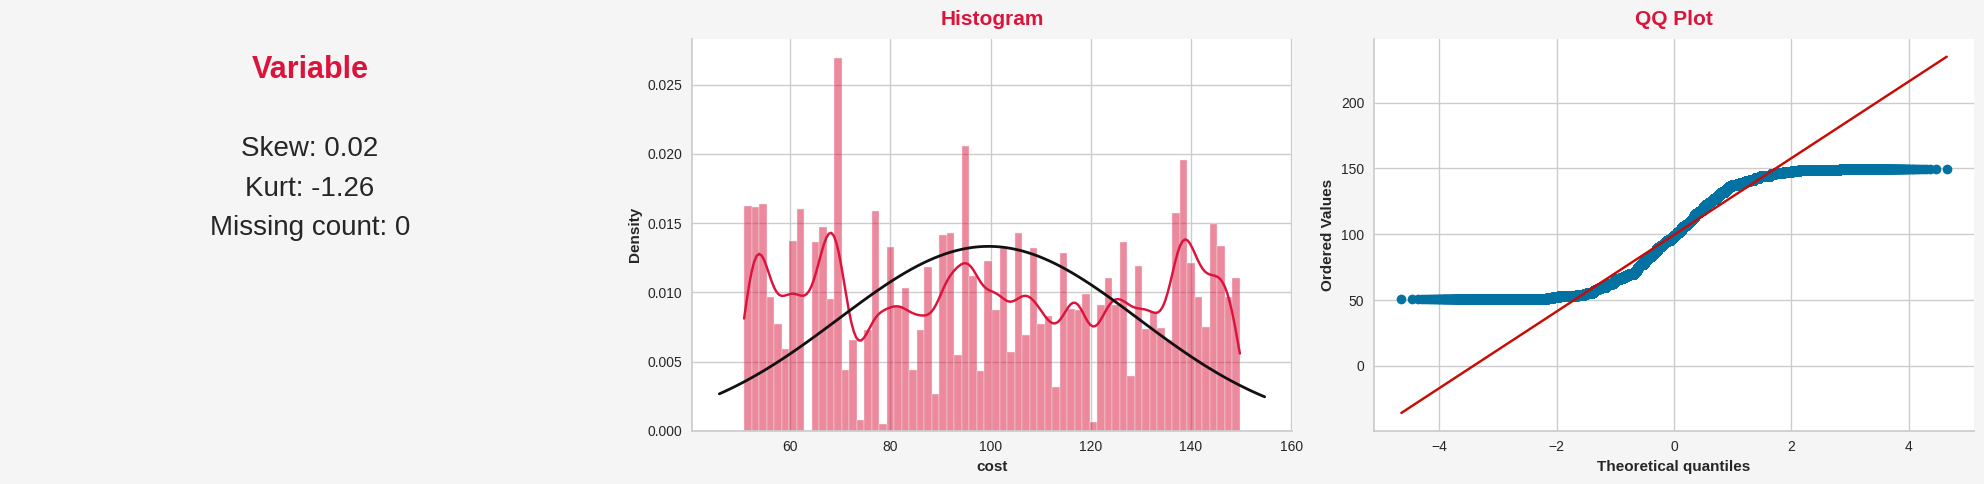

In [7]:
eda = my_EDA()
# dirp(eda)

#concact both train & original datasets
train2= train.copy()
y2 = train2.pop("cost")
eda.plot_variable_distribution(y2)
# eda.plot_variable_distribution(y2,use_yeo_johnson=True)

### 1. **¿Qué es la distribución KDE (Kernel Density Estimation)?**
La **KDE (Kernel Density Estimation)** (linea roja) es una técnica que se utiliza para estimar la función de densidad de probabilidad de una variable continua. Básicamente, te proporciona una representación suave de la distribución de los datos (la línea negra en tus histogramas). A diferencia del histograma, que agrupa los datos en bins, la KDE no depende de la agrupación, sino que asigna una función continua a cada punto, lo que puede ayudarte a ver patrones más claramente.

- **¿Para qué sirve?**
  - **Visualización**: Te ayuda a identificar cómo están distribuidos los datos (sesgo, multimodalidad, etc.).
  - **Identificación de problemas**: Te permite observar posibles distribuciones no normales o picos en los datos que pueden afectar a la precisión de los modelos de regresión.

### 2. **QQ Plot**
El **QQ Plot (Quantile-Quantile Plot)** te muestra cómo se alinean tus datos reales con una distribución teórica (normal en este caso). Si los puntos se alinean con la línea roja, significa que tus datos siguen una distribución normal. En tu caso, parece haber desviaciones, especialmente en los extremos, lo que indica que la variable "cost" no sigue perfectamente una distribución normal.

### 3. **Transformación de datos con Yeo-Johnson**
El segundo gráfico corresponde a una transformación de Yeo-Johnson, que es una técnica que intenta hacer que los datos se asemejen más a una distribución normal. Se utiliza para estabilizar la varianza y hacer que los datos cumplan mejor con los supuestos de modelos como la regresión lineal, que asumen que los errores tienen una distribución normal.

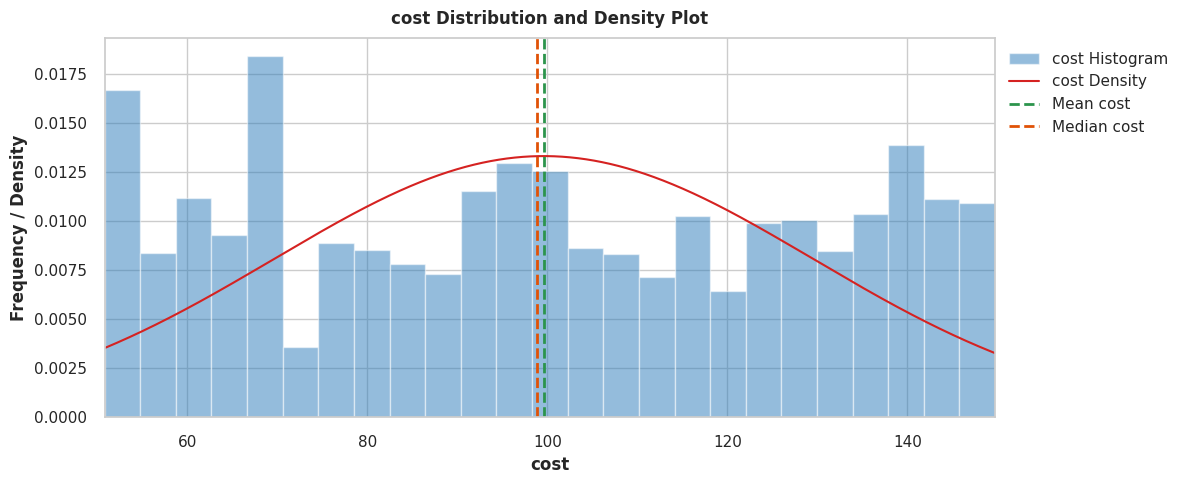

In [8]:
sns.set(style="whitegrid")
target = 'cost'

emission = train[target]

mean_emission = np.mean(emission)
median_emission = np.median(emission)

fig, ax = plt.subplots(figsize=(12, 5))

# HISTOGRAMA Y FUNCION DE DENSIDAD
ax.hist(emission, bins=25, density=True, alpha=0.5, label=f'{target} Histogram', color=sns.color_palette("Blues")[4])

x_values = np.linspace(emission.min(), emission.max(), len(emission))
density_values = (1 / (np.sqrt(2 * np.pi) * np.std(emission))) * np.exp(-0.5 * ((x_values - mean_emission) / np.std(emission))**2)
ax.plot(x_values, density_values, color=sns.color_palette("Reds")[4], label=f'{target} Density')

#LINEAS VERTICAS
ax.axvline(mean_emission, color=sns.color_palette("Greens")[4], linestyle='dashed', linewidth=2, label=f'Mean {target}')
ax.axvline(median_emission, color=sns.color_palette("Oranges")[4], linestyle='dashed', linewidth=2, label=f'Median {target}')

ax.set_xlabel(f'{target}')
ax.set_ylabel('Frequency / Density')
ax.set_title(f'{target} Distribution and Density Plot')

x_min = emission.min()
x_max = emission.max()
ax.set_xlim([x_min, x_max])
ax.legend(bbox_to_anchor=(1, 1), fancybox=False, shadow=False, loc='upper left')
plt.tight_layout()
plt.show()



Ahora podemos ver con mas detalle nuestro **histograma** con una **curva de densidad** superpuesta, junto con líneas que indican la **media** y la **mediana** de los datos. Este tipo de gráfico es útil para visualizar la **distribución de los datos**, entender la **tendencia central**, y detectar posibles **sesgos** o **asimetrías** en la variable.

### 1. **Histograma (barras azules):**
   - El histograma muestra la distribución de la variable **cost** en términos de frecuencia. En este caso, las barras representan cuántos valores caen dentro de cada rango específico de **cost**.
   - Se puede observar que la variable **cost** está distribuida de manera bastante dispersa, con varios picos y valles, lo que sugiere que no tiene una distribución muy uniforme ni estrictamente normal.
   - Los valores de **cost** oscilan entre aproximadamente **50 y 150**, con varios rangos con mayor frecuencia de datos, como alrededor de **60 y 100**.

### 2. **Curva de densidad (línea roja):**
   - La curva roja representa la **densidad de probabilidad estimada** para la variable **cost**. Es una versión suavizada del histograma, que ayuda a visualizar la distribución subyacente de los datos.
   - La densidad alcanza su pico más alto cerca de **100**, lo que indica que esa zona tiene la mayor concentración de datos.
   - La forma de la curva sugiere una distribución **asimétrica** (no completamente simétrica ni normal).

### 3. **Línea verde (Media):**
   - La línea verde punteada representa la **media** de la variable **cost**.
   - La media se encuentra alrededor de **100**, lo que indica que este es el valor promedio de los datos.
   - Como la curva de densidad es más elevada cerca de este punto, coincide con el área donde hay más datos.

### 4. **Línea naranja (Mediana):**
   - La línea naranja punteada representa la **mediana**, que es el valor central de los datos cuando se ordenan de menor a mayor.
   - La mediana también está cerca de **100**, lo que sugiere que la mitad de los datos tienen un valor inferior a este, y la otra mitad tiene un valor superior.
   - La cercanía entre la media y la mediana indica que los datos no están muy sesgados, aunque puede haber ligeros indicios de asimetría, debido a los valores en la cola derecha (valores mayores a 100).

### 5. **Comparación Media y Mediana:**
   - La media y la mediana están muy próximas, lo cual es un indicio de que no hay un sesgo muy fuerte en los datos. Sin embargo, si la distribución fuera perfectamente simétrica, ambas coincidirían exactamente.

### **Conclusión general:**
   - La distribución de **cost** parece ser asimétrica con una leve concentración alrededor de **100**.
   - La forma no sigue una distribución normal clásica (campana perfecta), sino que presenta algunos picos y valles.
   - Las líneas de media y mediana son útiles para entender la tendencia central de los datos, y ambas están alrededor de 100, sugiriendo que la mayoría de los costos están en esa región.



## 3.2 Numerical Feature Distributions

In [9]:
# sns.set_palette("Set2")

# cont_cols = [f for f in train.columns if train[f].dtype in [float, int] and train[f].nunique() > 2 and f not in [f'{target}']]

# num_rows = (len(cont_cols) + 2) // 3

# fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

# # Loop through each continuous column and plot the histograms
# for i, col in enumerate(cont_cols):
#     # Determine the range of values to plot
#     max_val = max(train[col].max(), test[col].max())
#     min_val = min(train[col].min(), test[col].min())
#     range_val = max_val - min_val

#     # Determine the bin size and number of bins
#     bin_size = range_val / 20
#     num_bins_train = round(range_val / bin_size)
#     num_bins_test = round(range_val / bin_size)

#     # Calculate the subplot position
#     row = i // 3
#     col_pos = i % 3

#     # Plot the histograms
#     sns.histplot(train[col], ax=axs[row][col_pos], kde=True, label='Train', bins=num_bins_train)
#     sns.histplot(test[col], ax=axs[row][col_pos], kde=True, label='Test', bins=num_bins_test)
#     axs[row][col_pos].set_title(col)
#     axs[row][col_pos].set_xlabel('Value')
#     axs[row][col_pos].set_ylabel('Frequency')
#     axs[row][col_pos].legend()

# # Remove any empty subplots
# if len(cont_cols) % 3 != 0:
#     for col_pos in range(len(cont_cols) % 3, 3):
#         axs[-1][col_pos].remove()

# plt.tight_layout()
# plt.show()

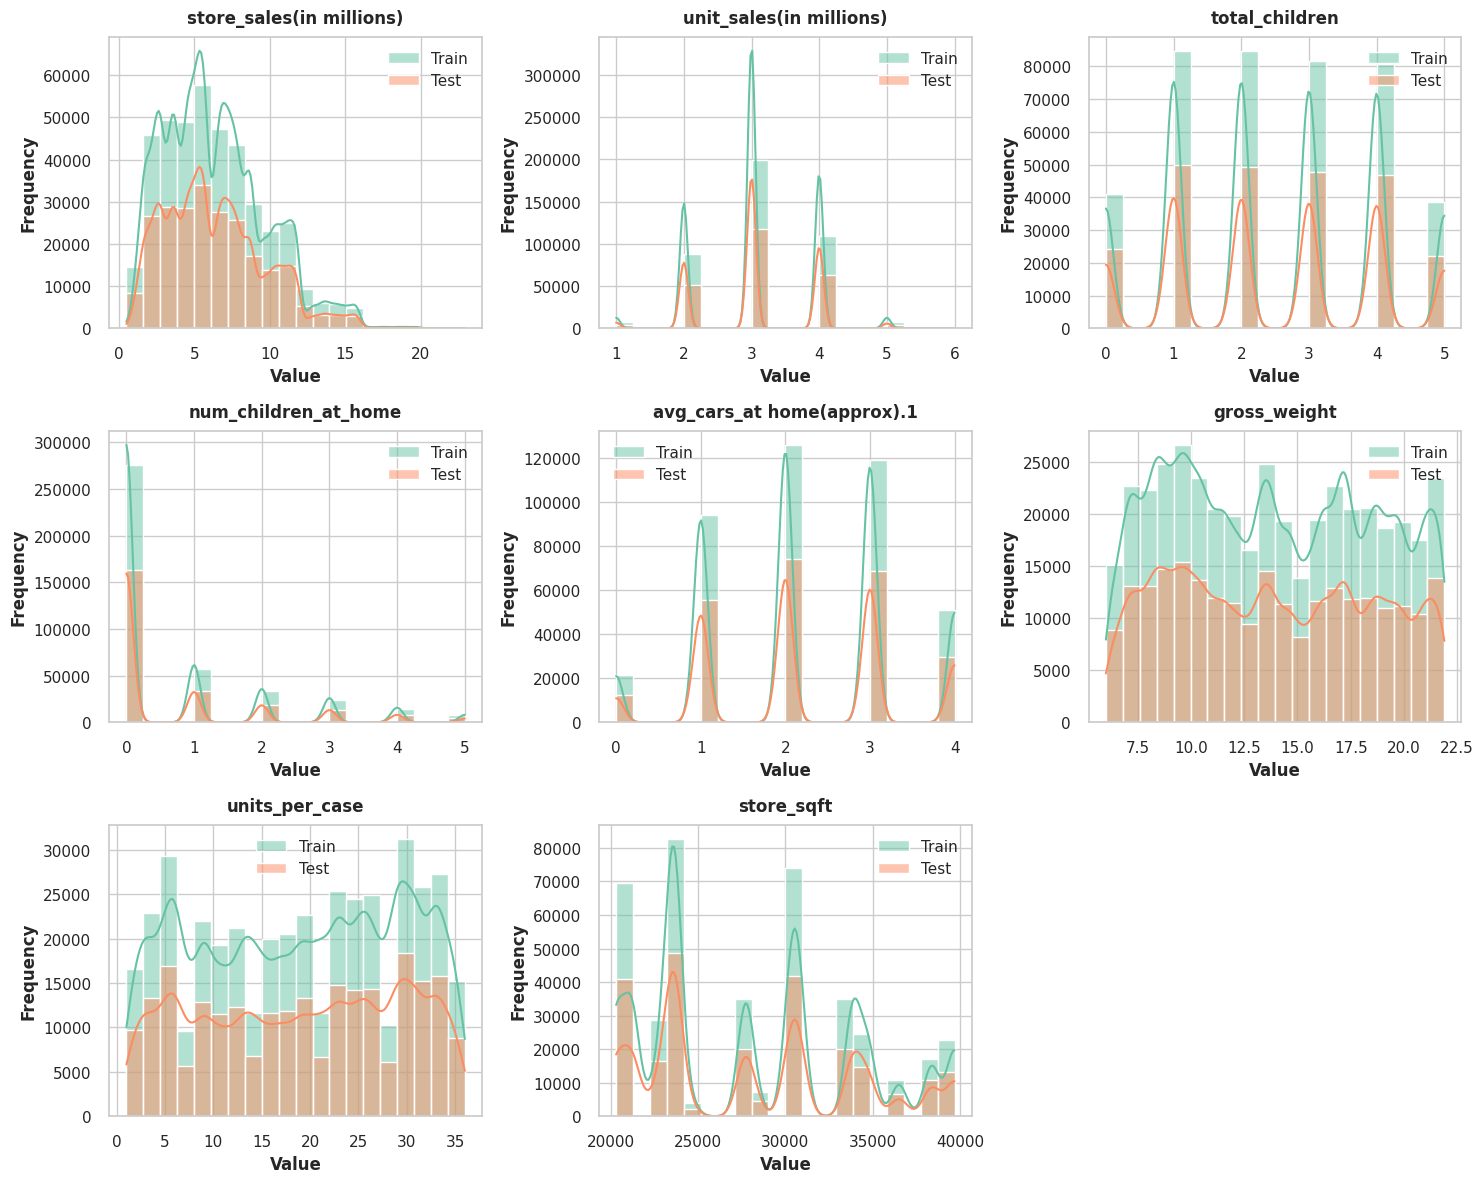

##  3.3 Correlation HeatMap

El mapa de calor representa la **matriz de correlación** entre diferentes variables, donde la variable objetivo es `cost`. La correlación mide la relación lineal entre dos variables, y va de -1 a 1:

- **1** significa una correlación positiva perfecta (cuando una sube, la otra también sube).
- **-1** significa una correlación negativa perfecta (cuando una sube, la otra baja).
- **0** significa que no hay correlación lineal.

### ¿Por qué se analiza una matriz de correlación?
La matriz de correlación es útil en modelos de aprendizaje automático supervisado porque te ayuda a:
   - **Identificar relaciones lineales**: Si algunas variables están muy correlacionadas con la variable objetivo, podrían ser buenos predictores.
   - **Detectar multicolinealidad**: Como se mencionó, las variables altamente correlacionadas entre sí (cercanas a 1 o -1) pueden afectar la estabilidad y la interpretación del modelo. Es importante reducir la multicolinealidad para obtener un modelo más robusto.

In [10]:
# corr = eda.plot_high_corr_heatmap(train, 'cost')
# Create a heatmap on a DataFramed
import plotly.express as px

# Calcular la matriz de correlación
corr_matrix = train.corr()

# Crear el heatmap usando plotly
fig = px.imshow(corr_matrix,
                labels=dict(color="Correlation"),
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                color_continuous_scale="Viridis",
                title="Heatmap de correlación")
fig.update_layout(width=800, height=800)
fig.show()

* No disponemos de una "gran" correlación con nuestro target: cost.

Esto es bueno y malo. Por un lado evitamos problemas relacionados a multicolinealidad en nuestros modelos de ML. Por otro lado, no vemos información clara que indique un cambio significativo con nuestra variable objetivo "cost".

## 4. FEATURE ENGINEERING

Para hacer combinaciones de características que tengan sentido desde una perspectiva científica (en este caso, de análisis de datos y predicción de costos), es clave buscar relaciones lógicas entre las variables que pueden ayudar a mejorar la predicción del **"Cost"** (el objetivo).

### **Ventas por unidad**
   - **Nueva característica**: `sales_per_unit = store_sales / unit_sales`
   - **Motivación**: Esta característica puede proporcionar información sobre el ingreso promedio por unidad vendida. Si el ingreso por unidad es bajo, puede implicar mayores costos de publicidad para lograr ventas.


###**Interacción entre autos en casa y ventas**
   - **Nueva característica**: `car_sales_interaction = avg_cars_at_home * store_sales`
   - **Motivación**: Los autos pueden ser una proxy del nivel de vida de los clientes. Una combinación de esta variable con las ventas puede revelar si los hogares con más autos gastan más, lo cual podría afectar los costos publicitarios.

## Create new features

In [11]:
def data_process(df):
  # sales_per_unit = store_sales / unit_sales
  df["sales_per_unit"] = df["store_sales(in millions)"]/df["unit_sales(in millions)"]

  # car_sales_interaction = avg_cars_at_home * store_sales
  df["car_sales_interaction"] = df["avg_cars_at home(approx).1"] * df["store_sales(in millions)"]
  return df

train=data_process(train)
test=data_process(test)

In [12]:
#PROTOTIPO VIEJO. Algoritmo de recuerdo y replicado en este notebook.
# PRIMERA VEZ QUE CONOCI LA Ingeniería de caracteristicas automatica (POR ALGORITMO).

# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import PowerTransformer

# # Transformations
# transformations = {
#     'log': lambda x: np.log(x + 1),
#     'sqrt': lambda x: np.sqrt(x),
#     'square': lambda x: x ** 2,
#     "y_J_": lambda x: PowerTransformer(method='yeo-johnson').fit_transform(np.array(x).reshape(-1, 1)),
#     "pow_": lambda x: np.power(x + 1, 0.25),
#     "pow2_": lambda x: np.power(x + 1, 2),
#     "log_sqrt": lambda x: np.log1p(np.sqrt(x))
# }

# # Store results
# results = []

# # Identify continuous columns
# cont_cols = [f for f in train.columns if pd.api.types.is_numeric_dtype(train[f]) and train[f].nunique() > 2 and f not in ['cost']]

# # Set number of splits for KFold
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Perform transformations and evaluate
# for col in cont_cols:
#     for trans_name, transformation in transformations.items():
#         mse_list = []

#         for train_index, test_index in kf.split(X):
#             X_transformed = X.copy()
#             X_transformed[col] = transformation(X_transformed[col])

#             # Splitting the data
#             X_train, X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
#             y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#             # Train model
#             model = LinearRegression()
#             model.fit(X_train, y_train)

#             # Predictions
#             y_pred = model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)

#         # Calculate average MSE for the current transformation
#         avg_mse = np.mean(mse_list)

#         # Store results
#         results.append((col, trans_name, avg_mse))

# # Convert results to DataFrame
# results_df = pd.DataFrame(results, columns=['Feature', 'Transformation', 'MSE'])

# # Select the best transformation for each feature
# best_transformations = results_df.loc[results_df.groupby('Feature')['MSE'].idxmin()]

# # Show the DataFrame with the best transformations
# display(best_transformations)


## Basic Functions

#### Funciones basicas

Esto es demostrativo y está bien documentado a fin de fomentar la reproducibilidad.

In [13]:
def min_max_scaler(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator uding overall min and max
    '''
    sc=MinMaxScaler()

    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)

    return train,test

def OHE(train_df,test_df,cols,target):
    '''
    Function for one hot encoding, it first combines the data so that no category is missed and
    the category with least frequency can be dropped because of redundancy
    '''
    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col+"_OHE" for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]

    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe

lgb_params = {
            'n_estimators': 100,
            'max_depth': 6,
            "num_leaves": 16,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'colsample_bytree': 0.8,
            #'reg_alpha': 0.25,
            'reg_lambda': 5e-07,
            'objective': 'regression_l2',
            'metric': 'mean_squared_error',
            'boosting_type': 'gbdt',
            'random_state': 42,
            'device': device,
        }
def rmse(y1,y2):
    '''  '''
    return(np.sqrt(mean_squared_error(np.array(y1),np.array(y2))))

def med_abs_error(y1,y2):
    ''' Median Absolute Error Evaluator'''
    return median_absolute_error(np.array(y1),np.array(y2))

def rmsle(y1, y2):
    """
    Calcula el Root Mean Squared Logarithmic Error (RMSLE) entre dos conjuntos de valores.
    >>Parámetros:
    y_true: array-like, valores reales
    y_pred: array-like, valores predichos
    >>Retorna:
    float, el RMSLE entre y_true y y_pred
    """
    # Agrega 1 a los valores reales y predichos y calcula el logaritmo natural (log1p) para evitar logaritmos de 0
    log_true = np.log1p(y1)
    log_pred = np.log1p(y2)
    return(np.sqrt(mean_squared_error(np.array(y1),np.array(y2))))


def store_missing_rows(df, features):
    '''Function stores where missing values are located for given set of features'''
    missing_rows = {}

    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()]

    return missing_rows

def fill_missing_numerical(train,test,target, max_iterations=10):
    '''Iterative Missing Imputer: Updates filled missing values iteratively using Boost Algorithm'''
    train_temp=train.copy()
    if target in train_temp.columns:
        train_temp=train_temp.drop(columns=target)


    df=pd.concat([train_temp,test],axis="rows")
    df=df.reset_index(drop=True)
    features=[ f for f in df.columns if df[f].isna().sum()>0]
    if len(features)>0:
        # Step 1: Store the instances with missing values in each feature
        missing_rows = store_missing_rows(df, features)

        # Step 2: Initially fill all missing values with "Missing"
        for f in features:
            df[f]=df[f].fillna(df[f].mean())

        cat_features=[f for f in df.columns if not pd.api.types.is_numeric_dtype(df[f])]
        dictionary = {feature: [] for feature in features}

        for iteration in tqdm(range(max_iterations), desc="Iterations"):
            for feature in features:
                # Skip features with no missing values
                rows_miss = missing_rows[feature].index

                missing_temp = df.loc[rows_miss].copy()
                non_missing_temp = df.drop(index=rows_miss).copy()
                y_pred_prev=missing_temp[feature]
                missing_temp = missing_temp.drop(columns=[feature])


                # Step 3: Use the remaining features to predict missing values using Random Forests
                X_train = non_missing_temp.drop(columns=[feature])
                y_train = non_missing_temp[[feature]]

                model= lgb.LGBMRegressor(**lgb_params)
                model.fit(X_train, y_train, verbose=False)

                # Step 4: Predict missing values for the feature and update all N features
                y_pred = model.predict(missing_temp)
                df.loc[rows_miss, feature] = y_pred
                # error_minimize=med_abs_error(y_pred,y_pred_prev)
                error_minimize=rmsle(y_pred,y_pred_prev)
                dictionary[feature].append(error_minimize)  # Append the error_minimize value

#         for feature, values in dictionary.items():
#             iterations = range(1, len(values) + 1)  # x-axis values (iterations)
#             plt.plot(iterations, values, label=feature)  # plot the values
#             plt.xlabel('Iterations')
#             plt.ylabel('RMSE')
#             plt.title('Minimization of RMSE with iterations')
#             plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#         plt.show()
        train[features] = np.array(df.iloc[:train.shape[0]][features])
        test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train,test

## 4.1 Transformaciones numéricas

Vamos a ver qué transformación funciona mejor para cada característica y a seleccionarlas, la idea es comprimir los datos. Podría haber situaciones en las que tengas que estirar los datos. Estos son los métodos aplicados:

----

Transformación logarítmica: esta transformación implica tomar el logaritmo de cada punto de datos. Es útil cuando los datos están muy sesgados y la varianza aumenta con la media.

    y = log(x)
Transformación de raíz cuadrada: esta transformación implica tomar la raíz cuadrada de cada punto de datos. Es útil cuando los datos están muy sesgados y la varianza aumenta con la media.

    y = sqrt(x)
Transformación de Box-Cox: esta transformación es una familia de transformaciones de potencia que incluye las transformaciones logarítmica y de raíz cuadrada como casos especiales. Es útil cuando los datos están muy sesgados y la varianza aumenta con la media.

    y = [(x^lambda) - 1] / lambda si lambda != 0
    y = log(x) si lambda = 0
Transformación de Yeo-Johnson: Esta transformación es similar a la transformación de Box-Cox, pero se puede aplicar tanto a valores positivos como negativos. Es útil cuando los datos están muy sesgados y la varianza aumenta con la media.

    y = [(|x|^lambda) - 1] / lambda si x >= 0, lambda != 0
    y = log(|x|) si x >= 0, lambda = 0
    y = -[(|x|^lambda) - 1] / lambda si x < 0, lambda != 2
    y = -log(|x|) si x < 0, lambda = 2
Transformación de potencia: Esta transformación implica elevar cada punto de datos a una potencia. Es útil cuando los datos están muy sesgados y la varianza aumenta con la media. La potencia puede ser cualquier valor y, a menudo, se determina mediante métodos estadísticos como las transformaciones de Box-Cox o Yeo-Johnson.

    y = [(x^lambda) - 1] / lambda si método = "box-cox" y lambda != 0
    y = log(x) si método = "box-cox" y lambda = 0
    y = [(x + 1)^lambda - 1] / lambda si método = "yeo-johnson" y x >= 0, lambda != 0
    y = log(x + 1) si método = "yeo-johnson" y x >= 0, lambda = 0
    y = [-(|x| + 1)^lambda - 1] / lambda si método = "yeo-johnson" y x < 0, lambda != 2
    y = -log(|x| + 1) si método = "yeo-johnson" y x < 0, lambda = 2

In [14]:
cont_cols = [f for f in train.columns if pd.api.types.is_numeric_dtype(train[f]) and train[f].nunique() >2 and f not in ['cost']]

sc=MinMaxScaler()

global unimportant_features
global overall_best_score
global overall_best_col
unimportant_features=[]
overall_best_score=100
overall_best_col='none'
dt_params={'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 8, 'criterion': 'absolute_error'}


def transformer(train, test,cont_cols, target):
    '''
    El algoritmo aplica múltiples transformaciones en columnas seleccionadas y encuentra la mejor transformación utilizando un modelo de rendimiento de una sola variable.

    trad.
    Algorithm applies multiples transformations on selected columns and finds the best transformation using a single variable model performance
    '''
    global unimportant_features
    global overall_best_score
    global overall_best_col
    train_copy = train.copy()
    test_copy = test.copy()
    table = PrettyTable()
    table.field_names = ['Feature', 'Initial RMSLE', 'Transformation', 'Tranformed RMSLE']

    for col in cont_cols:
        train, test=min_max_scaler(train, test, col)

        for c in ["log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col, "log_sqrt"+col, "pow_"+col, "pow2_"+col]:
            if c in train_copy.columns:
                train_copy = train_copy.drop(columns=[c]) # *


        # Log Transformation after MinMax Scaling (keeps data between 0 and 1)
        train_copy["log_"+col] = np.log1p(train_copy[col])
        test_copy["log_"+col] = np.log1p(test_copy[col])

        # Square Root Transformation
        train_copy["sqrt_"+col] = np.sqrt(train_copy[col])
        test_copy["sqrt_"+col] = np.sqrt(test_copy[col])

        # Box-Cox transformation
        combined_data = pd.concat([train_copy[[col]], test_copy[[col]]], axis=0)
        epsilon = 1e-5
        transformer = PowerTransformer(method='box-cox')
        scaled_data = transformer.fit_transform(combined_data + epsilon)

        train_copy["bx_cx_" + col] = scaled_data[:train_copy.shape[0]]
        test_copy["bx_cx_" + col] = scaled_data[train_copy.shape[0]:]

        # Yeo-Johnson transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_"+col] = transformer.transform(test_copy[[col]])

        # Power transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_"+col] = transformer.transform(test_copy[[col]])

        # Power transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_"+col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_"+col] = transformer.transform(test_copy[[col]])

        # Log to power transformation
        train_copy["log_sqrt"+col] = np.log1p(train_copy["sqrt_"+col])
        test_copy["log_sqrt"+col] = np.log1p(test_copy["sqrt_"+col])

        temp_cols = [col, "log_"+col, "sqrt_"+col, "bx_cx_"+col, "y_J_"+col,  "pow_"+col , "pow2_"+col,"log_sqrt"+col]

        train_copy, test_copy = fill_missing_numerical(train_copy, test_copy, target, 5)
#         train_copy[temp_cols] = train_copy[temp_cols].fillna(0)
#         test_copy[temp_cols] = test_copy[temp_cols].fillna(0)

        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[temp_cols])
        x_pca_test = pca.transform(test_copy[temp_cols])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        temp_cols.append(col+"_pca_comb")

        test_copy = test_copy.reset_index(drop=True)

        train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
        test_copy = pd.concat([test_copy, x_pca_test], axis='columns')

        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        # Eliminación de duplicados y de columnas con vaolres faltantes nan
        train_copy = train_copy.drop_duplicates()
        train_copy = train_copy.dropna()
        test_copy = test_copy.drop_duplicates()
        test_copy = test_copy.dropna()

        mae_scores = []

        for f in temp_cols:
            X = train_copy[[f]].values
            y = train_copy[target].values

            mae = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
                model=LinearRegression()
#                 model=DecisionTreeRegressor(**dt_params)
#                 model=HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01, loss="absolute_error",
#                                                   n_iter_no_change=300,random_state=42)
                model.fit(X_train,y_train)
                y_pred=model.predict(x_val)
                # mae.append(med_abs_error(y_val,y_pred))
                mae.append(rmsle(y_val,y_pred))
            mae_scores.append((f, np.mean(mae)))

            if overall_best_score > np.mean(mae):
                overall_best_score = np.mean(mae)
                overall_best_col = f

            if f == col:
                orig_mae = np.mean(mae)

        best_col, best_mae=sorted(mae_scores, key=lambda x:x[1], reverse=False)[0]

        cols_to_drop = [f for f in temp_cols if  f!= best_col and f not in col]
        final_selection=[f for f in temp_cols if f not in cols_to_drop]

        if cols_to_drop:
            unimportant_features = unimportant_features+cols_to_drop
        table.add_row([col,orig_mae,best_col ,best_mae])
    print(table)
    # EN GENERAL ...
    print("overall best CV root mean squared logaritmic error: ",overall_best_score)
    return train_copy, test_copy

train, test= transformer(train, test,cont_cols, "cost")


+----------------------------+--------------------+------------------------------------+--------------------+
|          Feature           |   Initial RMSLE    |           Transformation           |  Tranformed RMSLE  |
+----------------------------+--------------------+------------------------------------+--------------------+
|  store_sales(in millions)  | 29.948575795768342 |  log_sqrtstore_sales(in millions)  | 29.947705227662585 |
|  unit_sales(in millions)   | 29.941353037656768 |  log_sqrtunit_sales(in millions)   | 29.938964580877695 |
|       total_children       | 29.949719231622463 |         log_total_children         | 29.949098724318333 |
|    num_children_at_home    | 29.950584413582153 |     bx_cx_num_children_at_home     | 29.950386171061684 |
| avg_cars_at home(approx).1 | 29.940622534058708 | log_sqrtavg_cars_at home(approx).1 | 29.935890693212816 |
|        gross_weight        | 29.95004205475903  |          pow_gross_weight          | 29.95003702096718  |
|       un

In [15]:
train

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,original,sales_per_unit,car_sales_interaction,log_store_sales(in millions),sqrt_store_sales(in millions),bx_cx_store_sales(in millions),y_J_store_sales(in millions),pow_store_sales(in millions),pow2_store_sales(in millions),log_sqrtstore_sales(in millions),store_sales(in millions)_pca_comb,log_unit_sales(in millions),sqrt_unit_sales(in millions),bx_cx_unit_sales(in millions),y_J_unit_sales(in millions),pow_unit_sales(in millions),pow2_unit_sales(in millions),log_sqrtunit_sales(in millions),unit_sales(in millions)_pca_comb,log_total_children,sqrt_total_children,bx_cx_total_children,y_J_total_children,pow_total_children,pow2_total_children,log_sqrttotal_children,total_children_pca_comb,log_num_children_at_home,sqrt_num_children_at_home,bx_cx_num_children_at_home,y_J_num_children_at_home,pow_num_children_at_home,pow2_num_children_at_home,log_sqrtnum_children_at_home,num_children_at_home_pca_comb,log_avg_cars_at home(approx).1,sqrt_avg_cars_at home(approx).1,bx_cx_avg_cars_at home(approx).1,y_J_avg_cars_at home(approx).1,pow_avg_cars_at home(approx).1,pow2_avg_cars_at home(approx).1,log_sqrtavg_cars_at home(approx).1,avg_cars_at home(approx).1_pca_comb,log_gross_weight,sqrt_gross_weight,bx_cx_gross_weight,y_J_gross_weight,pow_gross_weight,pow2_gross_weight,log_sqrtgross_weight,gross_weight_pca_comb,log_units_per_case,sqrt_units_per_case,bx_cx_units_per_case,y_J_units_per_case,pow_units_per_case,pow2_units_per_case,log_sqrtunits_per_case,units_per_case_pca_comb,log_store_sqft,sqrt_store_sqft,bx_cx_store_sqft,y_J_store_sqft,pow_store_sqft,pow2_store_sqft,log_sqrtstore_sqft,store_sqft_pca_comb,log_sales_per_unit,sqrt_sales_per_unit,bx_cx_sales_per_unit,y_J_sales_per_unit,pow_sales_per_unit,pow2_sales_per_unit,log_sqrtsales_per_unit,sales_per_unit_pca_comb,log_car_sales_interaction,sqrt_car_sales_interaction,bx_cx_car_sales_interaction,y_J_car_sales_interaction,pow_car_sales_interaction,pow2_car_sales_interaction,log_sqrtcar_sales_interaction,car_sales_interaction_pca_comb
0,8.610,3.000,2.000,2.000,2.000,10.300,1.000,0.000,32.000,36509.000,0.000,0.000,0.000,0.000,0.000,62.090,0.000,2.870,17.220,2.263,2.934,0.762,0.766,1.737,82.810,1.370,83.355,1.386,1.732,-0.072,-0.075,1.316,9.000,1.005,9.838,1.099,1.414,-0.021,-0.258,1.316,9.000,0.881,9.419,1.099,1.414,1.437,1.502,1.316,9.000,0.881,9.627,1.099,1.414,-0.036,-0.180,1.316,9.000,0.881,9.463,2.425,3.209,-0.723,-0.725,1.517,28.090,1.437,29.121,3.497,5.657,1.220,1.229,2.378,1024.000,1.896,1024.521,10.505,191.073,1.314,1.317,11.280,262148481.000,5.258,262148483.513,1.353,1.694,0.858,0.861,1.389,13.838,0.991,14.446,2.903,4.150,0.499,0.507,2.066,331.968,1.639,332.340
1,5.000,2.000,4.000,0.000,3.000,6.660,1.000,0.000,1.000,28206.000,1.000,0.000,0.000,0.000,0.000,121.800,0.000,2.500,15.000,1.792,2.236,-0.267,-0.272,1.531,30.140,1.174,30.564,1.099,1.414,-1.325,-1.322,1.189,4.000,0.881,4.702,1.609,2.000,0.882,1.018,1.495,25.000,1.099,25.549,0.000,0.000,-0.699,-0.698,1.000,1.000,0.000,0.950,1.386,1.732,0.720,0.734,1.414,16.000,1.005,16.551,2.036,2.581,-1.685,-1.678,1.135,2.756,1.276,3.525,0.693,1.000,-1.982,-1.933,1.000,1.000,0.693,1.044,10.247,167.946,0.167,0.167,9.424,62220544.000,5.130,62220547.611,1.253,1.581,0.499,0.494,1.353,11.223,0.948,11.805,2.773,3.873,0.329,0.321,2.000,256.000,1.584,256.339
2,14.080,4.000,0.000,0.000,3.000,21.300,1.000,0.000,26.000,21215.000,1.000,0.000,0.000,0.000,0.000,83.510,0.000,3.520,42.240,2.713,3.752,1.908,1.902,1.954,212.285,1.559,212.770,1.609,2.000,1.217,1.209,1.414,16.000,1.099,16.832,0.000,0.000,-2.373,-1.774,1.000,1.000,0.000,0.919,0.000,0.000,-0.699,-0.698,1.000,1.000,0.000,0.950,1.386,1.732,0.720,0.734,1.414,16.000,1.005,16.551,3.105,4.615,1.516,1.521,2.009,265.690,1.725,266.543,3.296,5.099,0.706,0.705,2.258,676.000,1.80

* Nota: el RMSLE es mas eficiente en termions de uso de memoria qe el Med_abs_error de scikit learn

-----

4.2 Numerical Clustering

Se seleccionan todas las características consideradas sin importancia y que no son la mejor técnica de transformación, por lo que se les aplica una técnica de agrupamiento de K-means.



In [16]:
table = PrettyTable()
table.field_names = ['Cluster WOE Feature', 'RMSLE(CV-TRAIN)']
for col in cont_cols:
    sub_set=[f for f in unimportant_features if col in f]
#     print(sub_set)
    temp_train=train[sub_set]
    temp_test=test[sub_set]
    sc=StandardScaler()
    temp_train=sc.fit_transform(temp_train)
    temp_test=sc.transform(temp_test)
    model = KMeans()

    # print(ideal_clusters)
    kmeans = KMeans(n_clusters=12)
    kmeans.fit(np.array(temp_train))
    labels_train = kmeans.labels_

    train[col+"_unimp_cluster_WOE"] = labels_train
    test[col+"_unimp_cluster_WOE"] = kmeans.predict(np.array(temp_test))

#     cat_labels=cat_labels=train.groupby([col+"_unimp_cluster_WOE"])['emission'].mean()
#     cat_labels2=cat_labels.to_dict()
#     train[col+"_unimp_cluster_WOE"]=train[col+"_unimp_cluster_WOE"].map(cat_labels2)
#     test[col+"_unimp_cluster_WOE"]=test[col+"_unimp_cluster_WOE"].map(cat_labels2)

    kf=KFold(n_splits=5, shuffle=True, random_state=42)

    X=train[[col+"_unimp_cluster_WOE"]].values
    # Target
    y=train["cost"].values

    best_mae=[]
    for train_idx, val_idx in kf.split(X,y):
        X_train,y_train=X[train_idx],y[train_idx]
        x_val,y_val=X[val_idx],y[val_idx]
        model=LinearRegression()
#         model=HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01, loss="absolute_error",
#                                                   n_iter_no_change=300,random_state=42)
        model.fit(X_train,y_train)
        y_pred=model.predict(x_val)
        #best_mae.append(med_abs_error(y_val,y_pred))
        best_mae.append(rmsle(y_val,y_pred))

    table.add_row([col+"_unimp_cluster_WOE",np.mean(best_mae)])
    if overall_best_score<np.mean(best_mae):
            overall_best_score=np.mean(best_mae)
            overall_best_col=col+"_unimp_cluster_WOE"

print(table)

+----------------------------------------------+--------------------+
|             Cluster WOE Feature              |  RMSLE(CV-TRAIN)   |
+----------------------------------------------+--------------------+
|  store_sales(in millions)_unimp_cluster_WOE  | 29.949503298926043 |
|  unit_sales(in millions)_unimp_cluster_WOE   | 29.949961111435336 |
|       total_children_unimp_cluster_WOE       | 29.949358999366574 |
|    num_children_at_home_unimp_cluster_WOE    | 29.94940516653229  |
| avg_cars_at home(approx).1_unimp_cluster_WOE | 29.948695519893988 |
|        gross_weight_unimp_cluster_WOE        | 29.950009356621724 |
|       units_per_case_unimp_cluster_WOE       | 29.949946495082422 |
|         store_sqft_unimp_cluster_WOE         | 29.94794833861787  |
|       sales_per_unit_unimp_cluster_WOE       | 29.949914952435126 |
|   car_sales_interaction_unimp_cluster_WOE    | 29.948987920377128 |
+----------------------------------------------+--------------------+


## 4.3 Arithmetic Better Features

In [17]:
def better_features(train, test, target, cols, best_score):
    new_cols = []
    skf = KFold(n_splits=5, shuffle=True, random_state=42)  # Stratified k-fold object
    best_list=[]
    for i in tqdm(range(len(cols)), desc='Generating Columns'):
        col1 = cols[i]
        temp_df = pd.DataFrame()  # Temporary dataframe to store the generated columns
        temp_df_test = pd.DataFrame()  # Temporary dataframe for test data

        for j in range(i+1, len(cols)):
            col2 = cols[j]
            # Multiply
            temp_df[col1 + '*' + col2] = train[col1] * train[col2]
            temp_df_test[col1 + '*' + col2] = test[col1] * test[col2]

            # Divide (col1 / col2)
            temp_df[col1 + '/' + col2] = train[col1] / (train[col2] + 1e-5)
            temp_df_test[col1 + '/' + col2] = test[col1] / (test[col2] + 1e-5)

            # Divide (col2 / col1)
            temp_df[col2 + '/' + col1] = train[col2] / (train[col1] + 1e-5)
            temp_df_test[col2 + '/' + col1] = test[col2] / (test[col1] + 1e-5)

            # Subtract
            temp_df[col1 + '-' + col2] = train[col1] - train[col2]
            temp_df_test[col1 + '-' + col2] = test[col1] - test[col2]

            # Add
            temp_df[col1 + '+' + col2] = train[col1] + train[col2]
            temp_df_test[col1 + '+' + col2] = test[col1] + test[col2]

        SCORES = []
        for column in temp_df.columns:
            scores = []
            for train_index, val_index in skf.split(train, train[target]):
                X_train, X_val = temp_df[column].iloc[train_index].values.reshape(-1, 1), temp_df[column].iloc[val_index].values.reshape(-1, 1)
                y_train, y_val = train[target].iloc[train_index], train[target].iloc[val_index]
#                 model = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01, loss="absolute_error",
#                                                   n_iter_no_change=300,random_state=42)
                model=LinearRegression()
#                 model=DecisionTreeRegressor(**dt_params)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                # score = med_abs_error(y_val, y_pred)
                score = rmsle(y_val,y_pred)
                scores.append(score)
            mean_score = np.mean(scores)
            SCORES.append((column, mean_score))

        if SCORES:
            best_col, best_acc = sorted(SCORES, key=lambda x: x[1])[0]
            corr_with_other_cols = train.drop([target] + new_cols, axis=1).corrwith(temp_df[best_col])
#             print(corr_with_other_cols.abs().max())
            if (corr_with_other_cols.abs().max() < 0.9 or best_acc < best_score) and corr_with_other_cols.abs().max() !=1 :
                train[best_col] = temp_df[best_col]
                test[best_col] = temp_df_test[best_col]
                new_cols.append(best_col)
                print(f"Added column '{best_col}' with RMSLE: {best_acc:.4f} & Correlation {corr_with_other_cols.abs().max():.4f}")

    return train, test, new_cols


Todas las características creadas mediante combinaciones aritméticas se almacenan en una lista para que la próxima vez no tengamos que identificar nuevamente las mejores combinaciones y continuar directamente con los cálculos.

Estas transformaciones pueden capturar relaciones no lineales entre las variables que podrían ayudar a predecir mejor el costo de la campaña publicitaria.

------

### Nuevas columnas:
1. **`store_sales(in millions)+unit_sales(in millions)`**: Suma de ventas monetarias y ventas en unidades.
2. **`store_sales(in millions)-unit_sales(in millions)`**: Diferencia entre ventas monetarias y ventas en unidades.
3. **`total_children-num_children_at_home`**: Diferencia entre el número total de niños y los que están en casa.
4. **`total_children+avg_cars_at home(approx).1`**: Suma del número total de niños y el promedio de autos en casa.
5. **`avg_cars_at home(approx).1-gross_weight`**: Diferencia entre autos en casa y el peso bruto.
6. **`gross_weight-units_per_case`**: Diferencia entre peso bruto y unidades por caja.
7. **`unit_sales(in millions)-store_sqft`**: Diferencia entre ventas en unidades y el tamaño de la tienda en pies cuadrados.
8. **`gross_weight+store_sales(in millions)`**: Suma de peso bruto y ventas monetarias.
9. **`avg_cars_at home(approx).1*units_per_case`**: Producto entre el promedio de autos en casa y las unidades por caja.
10. **`store_sales(in millions)/store_sqft`**: Relación de ventas monetarias por pie cuadrado de tienda.
11. **`gross_weight/store_sqft`**: Relación entre el peso bruto de los productos y el tamaño de la tienda.

In [18]:
new_cols = [
    'store_sales(in millions)+unit_sales(in millions)',
    'store_sales(in millions)-unit_sales(in millions)',
    'total_children-num_children_at_home',
    'total_children+avg_cars_at home(approx).1',
    'avg_cars_at home(approx).1-gross_weight',
    'gross_weight-units_per_case',
    'unit_sales(in millions)-store_sqft',
    'gross_weight+store_sales(in millions)',
    'avg_cars_at home(approx).1*units_per_case',
    'store_sales(in millions)/store_sqft',
    'gross_weight/store_sqft'
]



In [19]:
def apply_arithmetic_operations(train_df, test_df, expressions_list):
    for expression in expressions_list:
        # Split the expression based on operators (+, -, *, /)
        parts = expression.split('+') if '+' in expression else \
                expression.split('-') if '-' in expression else \
                expression.split('*') if '*' in expression else \
                expression.split('/')

        # Get the DataFrame column names involved in the operation
        cols = [col for col in parts]

        # Perform the corresponding arithmetic operation based on the operator in the expression
        if cols[0] in train.columns and cols[1] in train.columns:
            if '+' in expression:
                train_df[expression] = train_df[cols[0]] + train_df[cols[1]]
                test_df[expression] = test_df[cols[0]] + test_df[cols[1]]
            elif '-' in expression:
                train_df[expression] = train_df[cols[0]] - train_df[cols[1]]
                test_df[expression] = test_df[cols[0]] - test_df[cols[1]]
            elif '*' in expression:
                train_df[expression] = train_df[cols[0]] * train_df[cols[1]]
                test_df[expression] = test_df[cols[0]] * test_df[cols[1]]
            elif '/' in expression:
                train_df[expression] = train_df[cols[0]] / (train_df[cols[1]]+1e-5)
                test_df[expression] = test_df[cols[0]] /( test_df[cols[1]]+1e-5)

    return train_df, test_df

train, test = apply_arithmetic_operations(train, test, new_cols)


## **4.4 Selección de Características**

**Pasos para eliminar características correlacionadas:**  
Se han creado muchas características a partir de las características originales utilizando transformaciones y técnicas de agrupamiento (clustering), las cuales estarían correlacionadas en cierta medida. Necesitamos identificar las mejores características entre ellas y eliminar las demás.

1. Agrupar las características basadas en su característica original.
2. Aplicar PCA (Análisis de Componentes Principales) al conjunto para crear un único componente principal (PC1) y codificación de agrupamiento orientado al objetivo (Cluster-Target Encoding) en el conjunto.
3. Ver el rendimiento de cada característica en el conjunto, junto con las nuevas características de PCA y Clustering, utilizando un modelo de una sola característica con validación cruzada y el objetivo.
4. Seleccionar la característica con el CV-RMSLE (RMSLE con Validación Cruzada) más alto.

In [20]:
final_drop_list=[]

table = PrettyTable()
table.field_names = ['Original', 'Final Transformation', 'RMSLE CV']
threshold=0.95
# It is possible that multiple parent features share same child features, so store selected features to avoid selecting the same feature again
best_cols=[]

for col in cont_cols:
    sub_set=[f for f in train.columns if col in f and train[f].nunique()>2]
#     print(sub_set)
    if len(sub_set)>2:
        correlated_features = []

        for i, feature in enumerate(sub_set):
            # Check correlation with all remaining features
            for j in range(i+1, len(sub_set)):
                correlation = np.abs(train[feature].corr(train[sub_set[j]]))
                # If correlation is greater than threshold, add to list of highly correlated features
                if correlation > threshold:
                    correlated_features.append(sub_set[j])

        # Remove duplicate features from the list
        correlated_features = list(set(correlated_features))
#         print(correlated_features)
        if len(correlated_features)>=2:

            # Eliminar filas con valores nulos y resetear los índices
            train.dropna(inplace=True)
            test.dropna(inplace=True)

            # Resetear el índice de ambos DataFrames
            train.reset_index(drop=True, inplace=True)
            test.reset_index(drop=True, inplace=True)

            temp_train=train[correlated_features]
            temp_test=test[correlated_features]
            #Scale before applying PCA
            sc=StandardScaler()
            temp_train=sc.fit_transform(temp_train)
            temp_test=sc.transform(temp_test)

            # Initiate PCA
            pca=TruncatedSVD(n_components=1)
            x_pca_train=pca.fit_transform(temp_train)
            x_pca_test=pca.transform(temp_test)
            x_pca_train=pd.DataFrame(x_pca_train, columns=[col+"_pca_comb_final"])
            x_pca_test=pd.DataFrame(x_pca_test, columns=[col+"_pca_comb_final"])

            train=pd.concat([train,x_pca_train],axis='columns')
            test=pd.concat([test,x_pca_test],axis='columns')

            train.dropna(inplace = True) # por si tenemos una operacion aritmetica estilo 1/0 = nan
            test.dropna(inplace = True)

            # Clustering
            model = KMeans()
            kmeans = KMeans(n_clusters=12)
            kmeans.fit(np.array(temp_train))



            labels_train = kmeans.labels_

            train[col+'_final_cluster'] = labels_train
            test[col+'_final_cluster'] = kmeans.predict(np.array(temp_test))

#             cat_labels=cat_labels=train.groupby([col+"_final_cluster"])['emission'].mean()
#             cat_labels2=cat_labels.to_dict()
#             train[col+"_final_cluster"]=train[col+"_final_cluster"].map(cat_labels2)
#             test[col+"_final_cluster"]=test[col+"_final_cluster"].map(cat_labels2)

            correlated_features=correlated_features+[col+"_pca_comb_final",col+"_final_cluster"]

            # See which transformation along with the original is giving you the best univariate fit with target
            kf=KFold(n_splits=5, shuffle=True, random_state=42)

            scores=[]

            for f in correlated_features:
                X=train[[f]].values
                y=train["cost"].values

                mae=[]
                for train_idx, val_idx in kf.split(X,y):
                    X_train,y_train=X[train_idx],y[train_idx]
                    x_val,y_val=X[val_idx],y[val_idx]

                    model=LinearRegression()
#                     model=HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.01, loss="absolute_error",
#                                                   n_iter_no_change=300,random_state=42)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(x_val)
                    # score = med_abs_error(y_val, y_pred)
                    score = rmsle(y_val, y_pred)
                    mae.append(score)
                if f not in best_cols:
                    scores.append((f,np.mean(mae)))
            best_col, best_acc=sorted(scores, key=lambda x:x[1], reverse=False)[0]
            best_cols.append(best_col)

            cols_to_drop = [f for f in correlated_features if  f not in best_cols]
            if cols_to_drop:
                final_drop_list=final_drop_list+cols_to_drop
            table.add_row([col,best_col ,best_acc])

print(table)


+----------------------------+--------------------------------------------------+--------------------+
|          Original          |               Final Transformation               |      RMSLE CV      |
+----------------------------+--------------------------------------------------+--------------------+
|  store_sales(in millions)  | store_sales(in millions)+unit_sales(in millions) | 29.946605480203186 |
|  unit_sales(in millions)   |         log_sqrtunit_sales(in millions)          | 29.938368095616248 |
|       total_children       |           total_children_final_cluster           | 29.945970383230957 |
|    num_children_at_home    |        num_children_at_home_final_cluster        | 29.948893561727193 |
| avg_cars_at home(approx).1 |        log_sqrtavg_cars_at home(approx).1        | 29.935589513426187 |
|        gross_weight        |     avg_cars_at home(approx).1-gross_weight      | 29.949390235786733 |
|       units_per_case       |               pow2_units_per_case         

## 5. Feature Selection



In [21]:
#TARGET
final_features=[feature for feature in train.columns if feature not in ['cost']]
final_features=[*set(final_features)]

scaler=StandardScaler()

train_scaled=train.copy()
test_scaled=test.copy()
train_scaled[final_features]=sc.fit_transform(train[final_features])
test_scaled[final_features]=sc.transform(test[final_features])

In [22]:
def post_processor(train, test):
    '''
    After Scaling, some of the features may be the same and can be eliminated
    '''
    #TARGET
    cols=[f for f in train.columns if "cost" not in f and "OHE" not in f]
    train_cop=train.copy()
    test_cop=test.copy()
    drop_cols=[]
    for i, feature in enumerate(cols):
        for j in range(i+1, len(cols)):
            if sum(abs(train_cop[feature]-train_cop[cols[j]]))==0:
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])
    print(drop_cols)
    train_cop.drop(columns=drop_cols,inplace=True)
    test_cop.drop(columns=drop_cols,inplace=True)

    return train_cop, test_cop


train_cop, test_cop = post_processor(train_scaled, test_scaled)

train_cop.to_csv('train_processed.csv',index=False)
test_cop.to_csv('test_processed.csv',index=False)


[]


In [32]:
X_train = train.drop(['cost'], axis=1)
y_train = train['cost']

X_test = test.copy()

print(X_train.shape, X_test.shape)

(411319, 139) (240224, 139)


In [34]:
def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
    'n_estimators': 300,  # Aumentar el número de estimadores puede ayudar a mejorar el rendimiento
    'max_depth': 8,       # Profundidad mayor puede capturar más complejidad en los datos
    'learning_rate': 0.01,  # Disminuir la tasa de aprendizaje para permitir más iteraciones
    'colsample_bytree': 0.8,  # Ajustar la proporción de columnas utilizadas
    'subsample': 0.7,        # Usar una muestra mayor puede ayudar a mejorar la generalización
    'min_child_weight': 1,   # Disminuir el peso mínimo de las hojas para capturar más patrones
    'reg_lambda': 1,         # Aumentar la regularización puede ayudar a reducir el sobreajuste
    'max_bin': 255,          # Ajustar el número máximo de bins para el manejo de datos
    'n_jobs': -1,            # Usar todos los núcleos disponibles
    'eval_metric': 'logloss',  # Cambiar a logloss para RMSLE
    'objective': 'reg:squarederror',  # Usar error cuadrático como objetivo
    'verbosity': 0,           # Sin salida de log
    'random_state': 42,
    }

    if device == 'gpu':
        xgb_params['tree_method'] = 'gpu_hist'  # Método para usar GPU
        xgb_params['predictor'] = 'gpu_predictor'  # Predictor para GPU


    lgb_params = {
    'n_estimators': 300,          # Aumentar el número de estimadores
    'max_depth': 8,               # Aumentar la profundidad máxima
    'num_leaves': 32,             # Aumentar el número de hojas
    'learning_rate': 0.01,        # Disminuir la tasa de aprendizaje
    'subsample': 0.8,             # Mayor proporción de muestreo
    'colsample_bytree': 0.8,      # Proporción de columnas utilizada
    'reg_alpha': 0.1,             # Añadir L1 regularization
    'reg_lambda': 1,              # Aumentar L2 regularization
    'objective': 'regression',    # Establecer como regresión
    'metric': 'rmse',             # Cambiar a rmse para optimizar RMSLE
    'boosting_type': 'gbdt',
    'random_state': 42,
    'device': 'gpu',              # Usar GPU
    }


    cb_params = {
    'iterations': 500,             # Aumentar el número de iteraciones
    'depth': 8,                    # Mantener profundidad alta
    'learning_rate': 0.01,         # Tasa de aprendizaje baja
    'random_strength': 0.5,        # Aumentar fuerza aleatoria
    'max_bin': 150,                # Mantener máximo de bins
    'od_wait': 100,                # Esperar más iteraciones para detenerse
    'one_hot_max_size': 70,
    'grow_policy': 'Depthwise',    # Mantener política de crecimiento
    'bootstrap_type': 'Bernoulli',
    'od_type': 'Iter',
    'eval_metric': 'RMSE',         # Cambiar a RMSE para optimizar RMSLE
    'loss_function': 'RMSE',        # Cambiar la función de pérdida
    'random_state': 42,
    'task_type': 'GPU',            # Usar GPU
    }

    if 'xgb' in model_input:
        model = xgb.XGBRegressor(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostRegressor(**cb_params)
    else:
        model=lgb.LGBMRegressor(**lgb_params)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    maes = []

    feature_importances_list = []

    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold,verbose=False)

        y_pred = model.predict(X_val_fold)

        #mae = med_abs_error(y_val_fold, y_pred)
        mae = rmsle(y_val_fold, y_pred)
        maes.append(mae)
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_mae= np.mean(maes)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:10]

    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {10} of {n} Feature Importances with MedAE score {avg_mae}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features

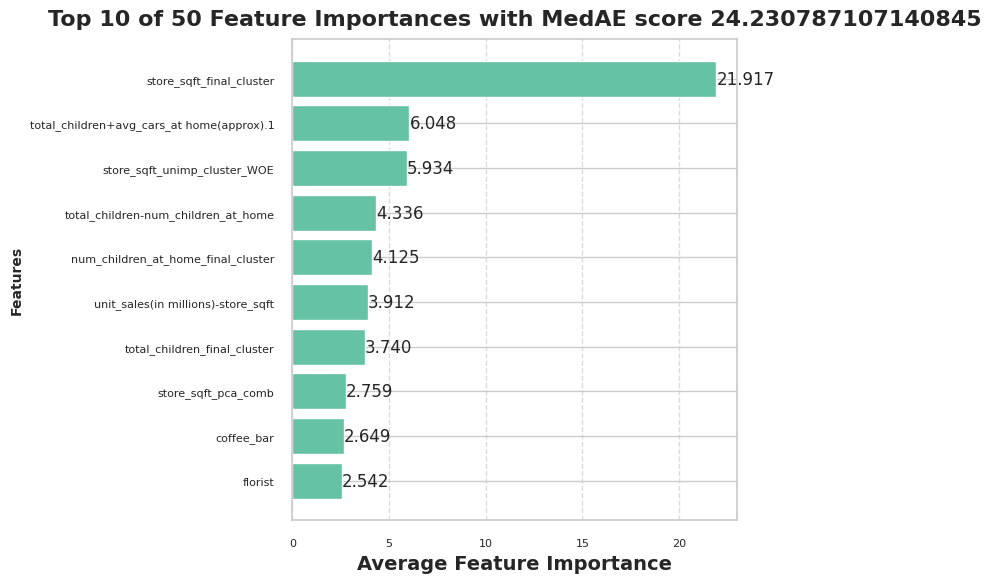

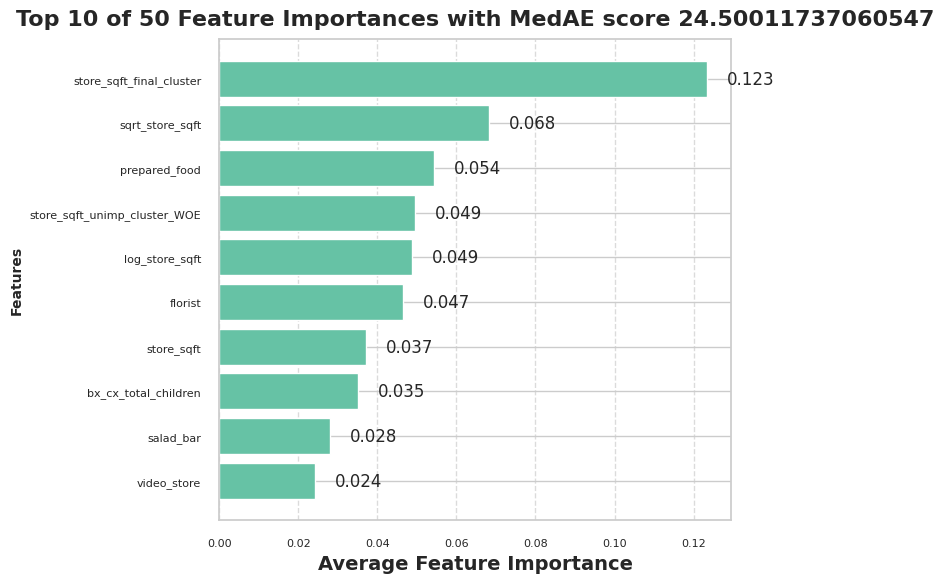

TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'verbose'

In [35]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'xgb')
# n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,50, 'lgbm')


In [36]:
n_imp_features=[*set(n_imp_features_xgb+n_imp_features_cat)]
print(f"{len(n_imp_features)} features have been selected from two algorithms for the final model")

61 features have been selected from two algorithms for the final model


In [37]:
X_train=train[n_imp_features]
X_test=test[n_imp_features]


# 6. Modeling

In [38]:
import tensorflow as tf
from tensorflow_probability import stats as tfp_stats
from tensorflow.keras import layers, callbacks

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LeakyReLU, PReLU, ELU
from keras.layers import Dropout
from keras import backend as K


In [45]:
sgd=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
rms = tf.keras.optimizers.RMSprop()
nadam=tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=100,
    restore_best_weights=True,
)


def med_abs_loss(y_true, y_pred):
    median = tfp_stats.percentile(tf.abs(y_pred - y_true), q=50.0)
    return median

def rmsle_loss(y_true, y_pred):
    # Asegúrate de que y_true y y_pred son tensores de tipo float para evitar problemas con el logaritmo.
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    # Agregar una pequeña constante (epsilon) para evitar log(0) que es indefinido.
    epsilon = tf.keras.backend.epsilon()

    # Calcular el logaritmo de (y_true + epsilon) y (y_pred + epsilon)
    log_true = tf.math.log(y_true + epsilon)
    log_pred = tf.math.log(y_pred + epsilon)

    # Calcular la diferencia cuadrática
    squared_diff = tf.square(log_true - log_pred)

    # Calcular la media de las diferencias cuadradas
    mean_squared_diff = tf.reduce_mean(squared_diff)

    # Retornar la raíz cuadrada de la media
    return tf.sqrt(mean_squared_diff)

def metric_fn(y_true, y_pred):
    return tfp_stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp_stats.percentile(tf.abs(y_true - y_pred), q=0)


In [47]:
ann = Sequential()
ann.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation=lrelu))
ann.add(Dropout(0.2))
ann.add(Dense(32,  kernel_initializer='he_uniform', activation=lrelu))
# ann.add(Dropout(0.1))
ann.add(Dense(4,  kernel_initializer='he_uniform', activation='relu'))
# ann.add(Dropout(0.1))
ann.add(Dense(2,  kernel_initializer='he_uniform', activation=lrelu))

ann.add(Dense(1,  kernel_initializer='he_uniform'))
ann.compile(loss=rmsle_loss, optimizer='adam')

ann2 = Sequential()
ann2.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer='he_uniform', activation=lrelu))
ann2.add(Dropout(0.2))
ann2.add(Dense(4,  kernel_initializer='he_uniform', activation=lrelu))
# ann.add(Dropout(0.1))
# ann.add(Dense(4,  kernel_initializer='he_uniform', activation='relu'))
# ann.add(Dropout(0.1))
ann2.add(Dense(2,  kernel_initializer='he_uniform', activation=lrelu))

ann2.add(Dense(1,  kernel_initializer='he_uniform'))
ann2.compile(loss=rmsle_loss, optimizer='adam')


## 6.1 Model Selection

best kernels

1)

Kudos to [tetsutani](http://www.kaggle.com/code/tetsutani/ps3e11-eda-xgb-lgbm-cat-ensemble-lb-0-29267) for a great modeling framework from where the below parts are adopted, please support the page if you like my work

2)

https://www.kaggle.com/code/arunklenin/ps3e25-material-hardness-prediction-with-ml/notebook#4.-FEATURE-ENGINEERING

In [41]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

class Regressor:
    def __init__(self, n_estimators=100, device="gpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.reg_models = self._define_reg_model()
        self.len_models = len(self.reg_models)

    def _define_reg_model(self):

        xgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 6,
            'learning_rate': 0.0116,
            'colsample_bytree': 1,
            'subsample': 0.6085,
            'min_child_weight': 9,
            'reg_lambda': 4.879e-07,
            'max_bin': 431,
            #'booster': 'dart',
            'n_jobs': -1,
            'eval_metric':'mae',
            'objective': "reg:absoluteerror",
            #'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'

        xgb_params1=xgb_params.copy()
        xgb_params1['subsample']=0.7
        xgb_params1['max_depth']=6
        xgb_params1['eval_metric']= lambda y_true, y_pred: med_abs_error(y_true, y_pred)
        xgb_params1['colsample_bytree']=0.6

        xgb_params2=xgb_params.copy()
        xgb_params2['subsample']=0.5
        xgb_params2['max_depth']=8
        xgb_params2['learning_rate']=0.047
        xgb_params2['colsample_bytree']=0.9
        xgb_params2['tree_method']='approx'

        lgb_params = {
            'n_estimators': self.n_estimators,
            'max_depth': 6,
            "num_leaves": 16,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'colsample_bytree': 0.8,
            #'reg_alpha': 0.25,
            'reg_lambda': 5e-07,
            'objective': 'mae',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        lgb_params1=lgb_params.copy()
        lgb_params1['subsample']=0.9
        lgb_params1['reg_lambda']=0.8994221730208598
        lgb_params1['reg_alpha']=0.6236579699090548
        lgb_params1['max_depth']=6
        lgb_params1['learning_rate']=0.01
        lgb_params1['colsample_bytree']=0.5

        lgb_params2=lgb_params.copy()
        lgb_params2['subsample']=0.1
        lgb_params2['reg_lambda']=0.5940716788024517
        lgb_params2['reg_alpha']=0.4300477974434703
        lgb_params2['max_depth']=8
        lgb_params2['learning_rate']=0.019000000000000003
        lgb_params2['colsample_bytree']=0.8

        lgb_params3 = {
            'n_estimators': self.n_estimators,
            'num_leaves': 45,
            'max_depth': 5,
            'learning_rate': 0.0684383311038932,
            'subsample': 0.5758412171285148,
            'colsample_bytree': 0.8599714680300794,
            'reg_lambda': 1.597717830931487e-08,
            'objective': 'mae',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'force_col_wise': True
        }
        lgb_params4=lgb_params.copy()
        lgb_params4['subsample']=0.3
        lgb_params4['reg_lambda']=0.5488355125638069
        lgb_params4['reg_alpha']=0.23414681424407247
        lgb_params4['max_depth']=7
        lgb_params4['learning_rate']=0.019000000000000003
        lgb_params4['colsample_bytree']=0.5

        cb_params = {
            'iterations': self.n_estimators,
            'depth': 6,
            'learning_rate': 0.02,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 80,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'IncToDec',
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'

        cb_params1 = {
            'iterations': self.n_estimators,
            'depth': 8,
            'learning_rate': 0.01,
            'l2_leaf_reg': 0.1,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 50,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bernoulli',
            'od_type': 'Iter',
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        cb_params2= {
            'n_estimators': self.n_estimators,
            'depth': 10,
            'learning_rate': 0.08827842054729117,
            'l2_leaf_reg': 4.8351074756668864e-05,
            'random_strength': 0.21306687539993183,
            'max_bin': 483,
            'od_wait': 97,
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
            'silent': True
        }
        dt_params= {'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 16, 'criterion': 'absolute_error'}
        knn_params= {'weights': 'uniform', 'p': 1, 'n_neighbors': 12, 'leaf_size': 20, 'algorithm': 'kd_tree'}

        reg_models = {
            'xgb_reg': xgb.XGBRegressor(**xgb_params),
            'xgb_reg1': xgb.XGBRegressor(**xgb_params1),
            'xgb_reg2': xgb.XGBRegressor(**xgb_params2),
            'lgb_reg': lgb.LGBMRegressor(**lgb_params),
            'lgb2_reg': lgb.LGBMRegressor(**lgb_params1),
            'lgb3_reg': lgb.LGBMRegressor(**lgb_params2),
            'lgb4_reg': lgb.LGBMRegressor(**lgb_params3),
            'lgb5_reg': lgb.LGBMRegressor(**lgb_params4),
            'lgb6_reg': lgb.LGBMRegressor(),
#             "hgbm": HistGradientBoostingRegressor(max_iter=self.n_estimators, learning_rate=0.01, loss="absolute_error",
#                                                   n_iter_no_change=300,random_state=self.random_state),
            'cat_reg': CatBoostRegressor(**cb_params),
            'cat_reg2': CatBoostRegressor(**cb_params1),
            'cat_reg3': CatBoostRegressor(**cb_params2),
            "cat_sym": CatBoostRegressor(**cb_sym_params),
            "cat_loss": CatBoostRegressor(**cb_loss_params),
#             'etr': ExtraTreesRegressor(min_samples_split=12, min_samples_leaf= 6, max_depth=16,
#                                        n_estimators=500,random_state=self.random_state),
#             'ann':ann,
#             'ann2':ann2,
#             "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=1000, learning_rate=0.02, max_depth=6,loss="absolute_error", random_state=self.random_state),
#             "RandomForestRegressor": RandomForestRegressor(max_depth= 6,max_features= 'auto',min_samples_split= 4,
#                                                            min_samples_leaf= 4,  n_estimators=500, random_state=self.random_state, n_jobs=-1),
#             'dt': DecisionTreeRegressor(**dt_params),

#             "lr":LinearRegression(),
#             "knn":KNeighborsRegressor(**knn_params),
#             "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=3000, tol=1e-3, n_iter_no_change=30, random_state=self.random_state),
#             "HuberRegressor": HuberRegressor(max_iter=3000),




        }


        return reg_models


## 6.2 Weighted Esembling

In [49]:
import optuna
class OptunaWeights:
    def __init__(self, random_state):
        self.study = None
        self.weights = None
        self.random_state = random_state

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the MedAE score for the weighted prediction
        #score = med_abs_error(y_true, weighted_pred)
        score = rmsle(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds, n_trials=10000):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds, n_trials=10000):
        self.fit(y_true, y_preds, n_trials=n_trials)
        return self.predict(y_preds)

    def weights(self):
        return self.weights

def create_model(n_cols):

    input_layer = tf.keras.Input(shape=(n_cols, ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation=lrelu)(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation=lrelu)(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.013, beta_1=0.5),
                  loss=rmsle_loss,
                  metrics=metric_fn)

    return model
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
    ]


In [52]:
!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.1
    Uninstalling xgboost-2.1.1:
      Successfully uninstalled xgboost-2.1.1


## 6.3 Model Fit


Este código implementa una estrategia de validación cruzada para varios modelos de regresión, ajustando y evaluando su rendimiento, y luego combinando las predicciones mediante un método de optimización de pesos. El uso de técnicas como early stopping y la creación de nuevas características a partir de las predicciones contribuyen a mejorar la calidad del modelo final.

### Importaciones
```python
import numpy as np
import gc
from copy import deepcopy
```
- **numpy**: Usado para realizar operaciones numéricas y manejar arrays.
- **gc**: El recolector de basura de Python, que se utiliza aquí para liberar memoria.
- **deepcopy**: Permite crear copias profundas de objetos, útil para guardar modelos entrenados sin que se vean afectados por futuros cambios.

### Configuración Inicial
```python
kfold = True
n_splits = 1 if not kfold else 4
random_state = 42
random_state_list = [42]
n_estimators = 9999
early_stopping_rounds = 600
verbose = False
device = 'cpu'
```
- **kfold**: Indica si se utilizará validación cruzada.
- **n_splits**: Número de divisiones en k-fold; si `kfold` es falso, se establece en 1, de lo contrario en 4.
- **random_state**: Semilla para la reproducibilidad de resultados.
- **random_state_list**: Lista de estados aleatorios; aquí solo contiene el 42.
- **n_estimators**: Número máximo de estimadores a utilizar en los modelos (particularmente en modelos de árboles).
- **early_stopping_rounds**: Número de rondas para detener el entrenamiento si no hay mejoras.
- **verbose**: Controla la salida de información durante el ajuste de los modelos.
- **device**: Define el dispositivo en el que se ejecutará el código (CPU en este caso).

### Creación del Splitter
```python
splitter = Splitter(kfold=kfold, n_splits=n_splits)
```
- Se crea una instancia de `Splitter`, que probablemente es una clase personalizada que gestiona la división de los datos en conjuntos de entrenamiento y validación.

### Inicialización de Predicciones
```python
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []
trained_models = dict(zip(Regressor().reg_models.keys(), [[] for _ in range(Regressor().len_models)]))
```
- **test_predss**: Inicializa un array para almacenar las predicciones sobre el conjunto de prueba.
- **ensemble_score**: Lista para almacenar las puntuaciones de cada modelo del ensemble.
- **weights**: Lista para almacenar los pesos de cada modelo en el ensemble.
- **trained_models**: Inicializa un diccionario para almacenar modelos entrenados, donde las claves son los nombres de los modelos.

### Evaluación de Modelos
```python
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits

    reg = Regressor(n_estimators, device, random_state)
    models = reg.reg_models
```
- Un bucle que itera a través de las divisiones de los datos.
- Para cada división, se obtienen los conjuntos de entrenamiento y validación.
- Se crea una instancia de `Regressor`, que probablemente inicializa varios modelos de regresión.

### Entrenamiento de Modelos

- Para cada modelo, se ajusta según el tipo de modelo (XGBoost, ANN, etc.).
- Si el modelo es de tipo árbol (XGBoost, CatBoost), se ajusta utilizando un conjunto de validación y se genera una nueva característica `cost_pred`.
- Si el modelo es una red neuronal (ANN), se ajusta directamente con los datos de entrenamiento y validación.
- Se generan predicciones para los conjuntos de validación y prueba.

### Cálculo de la Puntuación
```python
score = rmsle(y_val, y_val_pred)
print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] RMSLE score: {score:.5f}')

oof_preds.append(y_val_pred)
test_preds.append(test_pred)
trained_models[name].append(deepcopy(model))
```
- Se calcula la puntuación RMSLE para las predicciones de validación y se imprime.
- Se almacenan las predicciones de validación y prueba, así como los modelos entrenados.

### Ensemble y Optimización de Pesos
```python
optweights = OptunaWeights(random_state=random_state)
y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
score = rmsle(y_val, y_val_pred)

print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] RMSLE score: {score:.5f}')
ensemble_score.append(score)
weights.append(optweights.weights)
test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))

gc.collect()
```
- Utiliza Optuna para encontrar los mejores pesos para el ensemble de modelos.
- Calcula la puntuación RMSLE del ensemble y la imprime.
- Se actualiza el array de predicciones de prueba con los resultados del ensemble.
- Se llama a `gc.collect()` para liberar memoria.



In [ ]:
import numpy as np
import gc
from copy import deepcopy

kfold = True
n_splits = 1 if not kfold else 4
random_state = 42
random_state_list = [42]
n_estimators = 9999
early_stopping_rounds = 600
verbose = False
device = 'cpu'

splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros(X_test.shape[0])
ensemble_score = []
weights = []
trained_models = dict(zip(Regressor().reg_models.keys(), [[] for _ in range(Regressor().len_models)]))

# Evaluate on validation data and store predictions on test data
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits

    # Get a set of Regressor models
    reg = Regressor(n_estimators, device, random_state)
    models = reg.reg_models

    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []

    # Loop over each base model
    for name, model in models.items():
        try:
            # Fit models with specific handling for different types
            if name in ['cat', 'xgb']:
                model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)],
                          early_stopping_rounds=early_stopping_rounds, verbose=verbose)

                # Create predictions for new features
                X_new = X_train_.copy()
                X_new['cost_pred'] = model.predict(X_new)

                # Create and fit the neural network model
                model_nn = create_model(X_new.shape[1])
                history = model_nn.fit(X_new.astype('float32'), y_train_.astype('float32'),
                                       epochs=100,
                                       class_weight=model.class_weight if hasattr(model, 'class_weight') else None,
                                       callbacks=callbacks_list,
                                       validation_split=0.1, verbose=verbose)

            elif 'ann' in name:
                model.fit(X_train_, y_train_, validation_data=(X_val, y_val), epochs=1000,
                          callbacks=[early_stopping], verbose=verbose)
            else:
                model.fit(X_train_, y_train_)

            # Generate predictions
            if 'ann' in name:
                y_val_pred = model.predict(X_val).flatten()
                test_pred = model.predict(X_test).flatten()
            else:
                X_val_temp = X_val.copy()
                X_val_temp['cost_pred'] = model.predict(X_val)
                y_val_pred = model_nn.predict(X_val_temp.astype('float32')).flatten()

                test_temp = X_test.copy()
                test_temp['cost_pred'] = model.predict(test_temp)
                test_pred = model_nn.predict(test_temp.astype('float32')).flatten()

            # Calculate RMSLE score
            score = rmsle(y_val, y_val_pred)
            print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] RMSLE score: {score:.5f}')

            oof_preds.append(y_val_pred)
            test_preds.append(test_pred)
            trained_models[name].append(deepcopy(model))

        except Exception as e:
            print(f"Error fitting model {name}: {e}")

    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    score = rmsle(y_val, y_val_pred)

    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] RMSLE score: {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))

    gc.collect()


Error fitting model xgb_reg: name 'model_nn' is not defined


In [ ]:
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble RMSLE score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name} {mean_weight:.5f} ± {std_weight:.5f}')


## 6.4 Feature Importance

In [ ]:
def visualize_importance(models, feature_cols, title, top=10):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(top)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)

    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    sns.set_palette("Set2")
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance, errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance [Top {top}]', fontsize=15)
    plt.grid(True, axis='x')
    plt.show()

for name, models in trained_models.items():
    visualize_importance(models, list(X_train.columns), name)


In [ ]:
X = train_copy.drop(columns='cost')
y = train_copy.cost

model_pre = lgb.LGBMRegressor()
model_pre.fit(X, y)
X_new = X.copy()
X_new['cost_pred'] = model_pre.predict(X)

model = create_model(X_new.shape[1])
history = model.fit(X_new.astype('float32'), y.astype('float32'),
                    epochs=100,
                    class_weight=model_pre.class_weight,
                    callbacks=callbacks_list,
                    validation_split=0.1)

test_copy['costs_pred'] = model_pre.predict(test_copy.astype('float32'))
sub_external=sub.copy()
sub_external["cost"] = model.predict(test_copy.astype('float32'))

sub_external.to_csv('submission.csv',index=False)